In [1]:
library(miloR)
library(SingleCellExperiment)
library(scater)
library(dplyr)
library(patchwork)

Loading required package: edgeR

Loading required package: limma

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedi

In [2]:
obj = qs::qread('../00_preprocessing/_targets/objects/exp_other_obob')
obj

Loading required package: SeuratObject

Attaching sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Loading required package: Seurat


Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays




An object of class Seurat 
56583 features across 28456 samples within 3 assays 
Active assay: SCT (24262 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [3]:
sce = as.SingleCellExperiment(obj)
sce

class: SingleCellExperiment 
dim: 24262 28456 
metadata(0):
assays(2): counts logcounts
rownames(24262): Lypla1 Tcea1 ... Olfr187 ENSMUSG00000100896
rowData names(0):
colnames(28456): CCTATCGAGCCATTCA_1_1 GTCCTCAAGCGAGGAG_1_1 ...
  TTAATCCGTGATAGTA_5_3 TCACTCGAGGATACCG_5_3
colData names(35): orig.ident nCount_RNA ... labels ident
reducedDimNames(2): PCA UMAP
mainExpName: SCT
altExpNames(2): RNA integrated

In [8]:
reducedDim(sce, "PCA", withDimnames=TRUE) <- obj[['pca']]@cell.embeddings

In [10]:
sce <- runUMAP(sce, dimred='PCA', name = 'UMAP', n_dimred = 30)

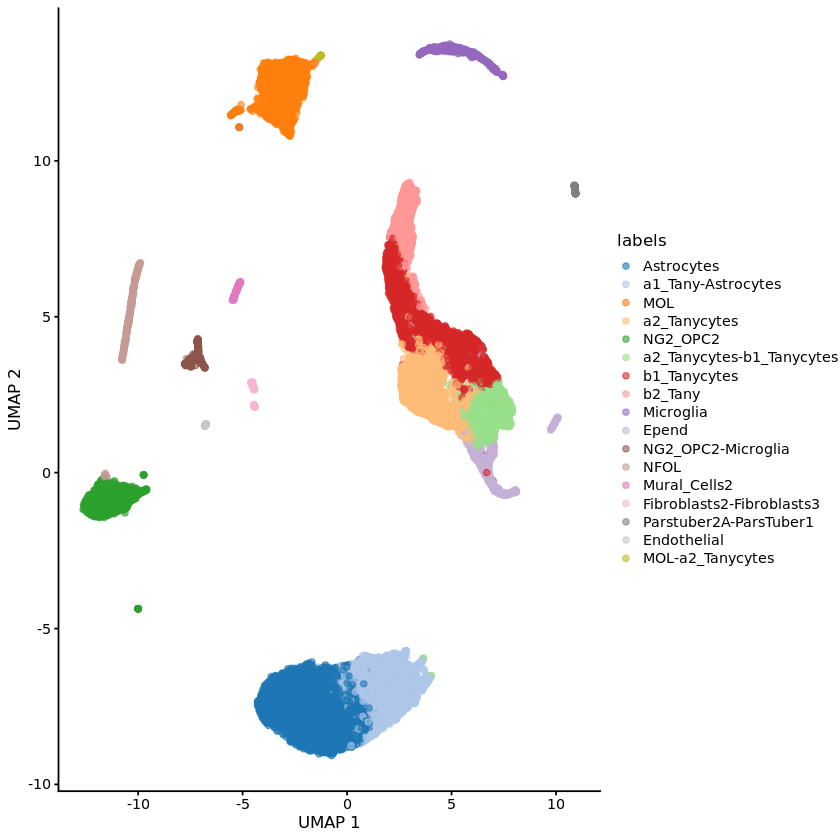

In [11]:
plotReducedDim(sce, colour_by = 'labels', dimred='UMAP')

In [24]:
glia_milo <- Milo(sce)

#build KNN graph
glia_milo <- buildGraph(glia_milo, k=40, d=30, reduced.dim = 'PCA')

#define neighbourhoods
glia_milo <- makeNhoods(glia_milo, prop = 0.1, k= 40, d=30, refined = T, reduced_dims = 'PCA')

Constructing kNN graph with k:40

Checking valid object

Running refined sampling with reduced_dim



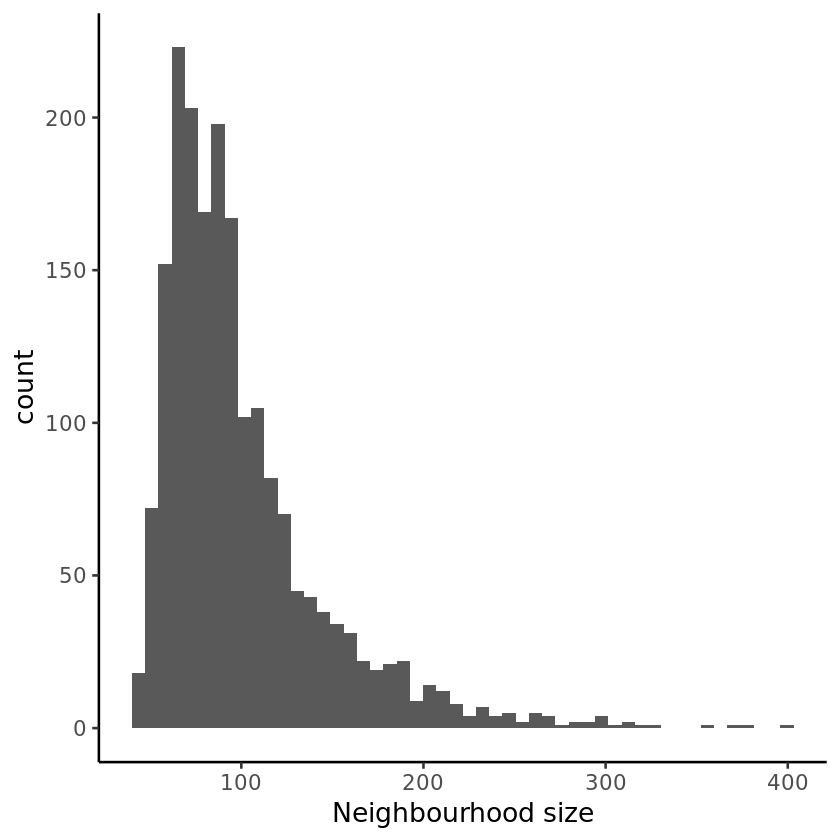

In [25]:
#plot neighbourhood sizes to check if we used appropriate k for graph building
  #we want to have an average size over 5 x N_samples
  #we have 171 samples - but not all samples will be in all neighbourhoods because of age variance
plotNhoodSizeHist(glia_milo)

Checking meta.data validity

Counting cells in neighbourhoods



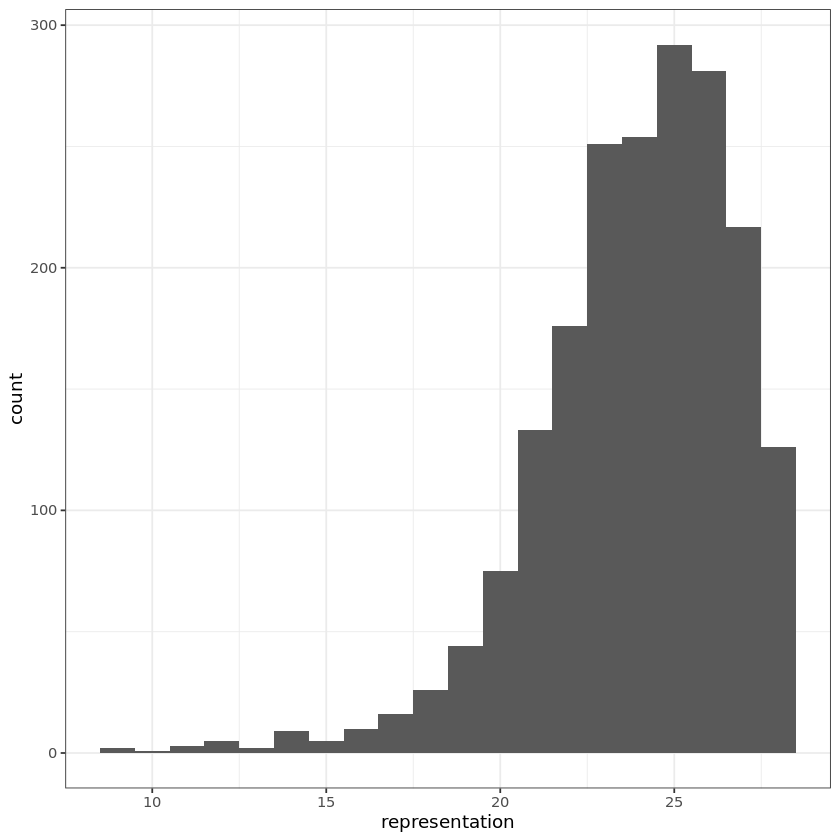

In [27]:
#add a n x m matrix to the milo object with number of neighbourhodds and samples
glia_milo <- countCells(glia_milo, meta.data = as.data.frame(colData(glia_milo)), sample = 'hash.mcl.ID')

#calculate sample representation in each neighbourhood
cell_counts <- as.data.frame(nhoodCounts(glia_milo)) %>% mutate(representation = rowSums(.>0))

#view distribution of N_samples in each neigbourhood
ggplot(cell_counts, aes(x = representation)) + 
  geom_histogram(binwidth = 1) + theme_bw()

#most neighbourhoods have 30-60 samples in them

In [34]:
glia_design <- data.frame(colData(glia_milo))[, c('hash.mcl.ID', 'treatment', 'batch')]
#convert seq-pool to factor
glia_design$batch <- as.factor(glia_design$batch)
#keep unique rows
glia_design <- distinct(glia_design)
#change rownames
rownames(glia_design) <- glia_design$hash.mcl.ID
head(glia_design)

,hash.mcl.ID,treatment,batch
,<chr>,<fct>,<fct>
M13,M13,FGF1,Batch 1
N7,N7,FGF1,Batch 1
J11,J11,FGF1,Batch 1
M8,M8,Veh_PF,Batch 1
J2,J2,Veh_PF,Batch 1
M24,M24,Veh_PF,Batch 1


In [35]:
#store distances to nearest neighbours
glia_milo <- calcNhoodDistance(glia_milo, d=30, reduced.dim = 'PCA')

In [36]:
qs::qsave(glia_milo, 'glia_milo.qs')

In [42]:
da_results <- testNhoods(glia_milo, design = ~ 0 + batch + treatment, design.df = glia_design)

da_results %>%
  arrange(SpatialFDR) %>%
  head() 

Using TMM normalisation

Performing spatial FDR correction withk-distance weighting



,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
152,-4.203933,9.475064,38.13095,2.842732e-08,5.480787e-05,152,0.0001196847
432,-3.835815,9.392309,32.58589,2.005840e-07,7.734520e-05,432,0.0001670789
612,-3.189284,9.372112,33.00404,1.724691e-07,7.734520e-05,612,0.0001670789
1629,-3.881944,9.460885,33.41891,1.485618e-07,7.734520e-05,1629,0.0001670789
1761,-4.139487,9.235960,33.12414,1.651672e-07,7.734520e-05,1761,0.0001670789
182,-3.740257,9.513395,30.92042,4.455074e-07,1.425225e-04,182,0.0003103025


In [43]:
table(da_results$FDR < 0.05)


FALSE  TRUE 
 1872    56 

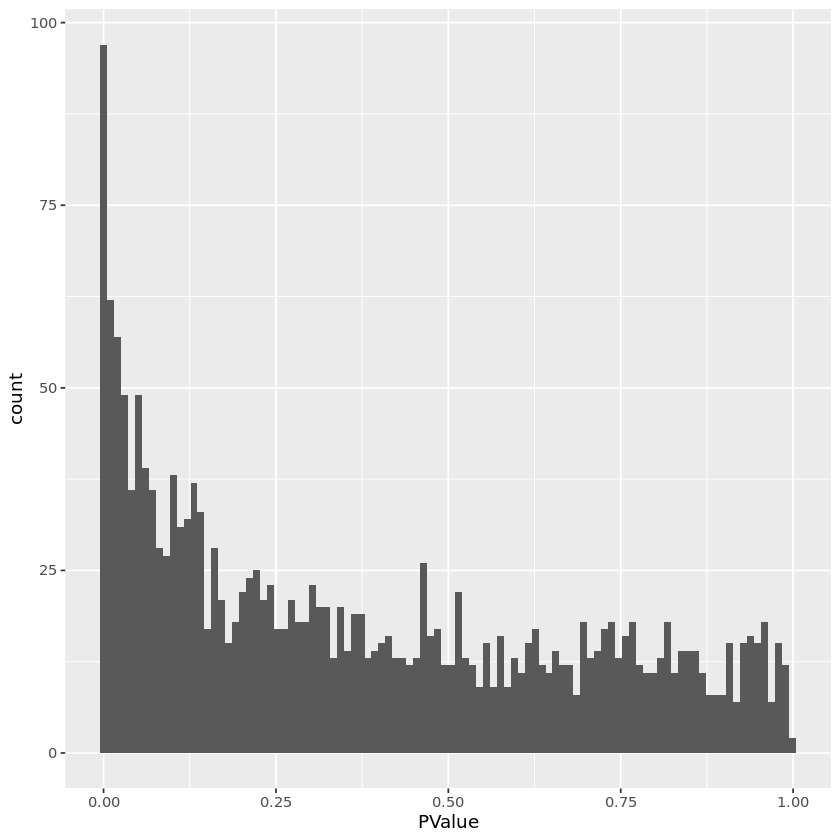

In [44]:
ggplot(da_results, aes(PValue)) + geom_histogram(bins=100)

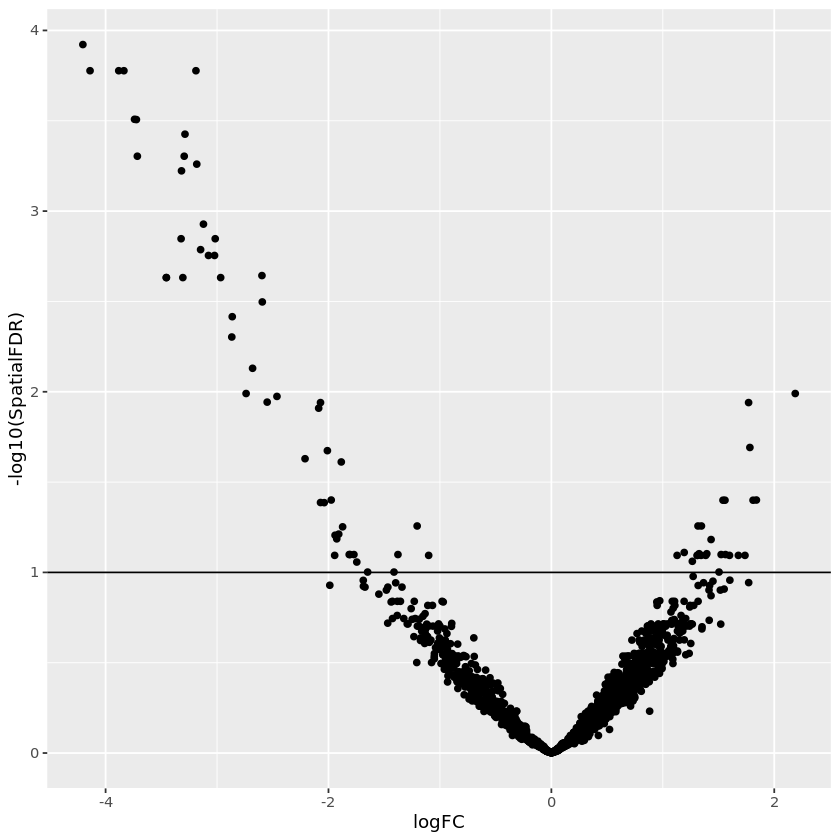

In [45]:
ggplot(da_results, aes(logFC, -log10(SpatialFDR))) + 
  geom_point() +
  geom_hline(yintercept = 1) ## Mark significance threshold (10% FDR)

In [46]:
glia_milo <- buildNhoodGraph(glia_milo)

In [48]:
head(data.frame(colData(glia_milo)))

,orig.ident,nCount_RNA,nFeature_RNA,Index.10x,nCount_HTO,nFeature_HTO,Index.HTO,nCount_spliced,nFeature_spliced,nCount_unspliced,⋯,strain,treatment,time,collection_date,isolation_date,batch,predicted.id,prediction.score.max,labels,ident
,<chr>,<dbl>,<int>,<chr>,<dbl>,<int>,<chr>,<dbl>,<int>,<dbl>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<chr>,<dbl>,<fct>,<fct>
CCTATCGAGCCATTCA_1_1,SI-TT-A11,49695,7017,SI-TT-A11,1473,12,D706,7105,3206,42590,⋯,obob,FGF1,Day14,220407,22/6/2022,Batch 1,NG2_OPC2,0.3917772,NG2_OPC2-Microglia,12
GTCCTCAAGCGAGGAG_1_1,SI-TT-A11,41375,6414,SI-TT-A11,2757,12,D706,6392,2838,34983,⋯,obob,FGF1,Day5,211213,22/6/2022,Batch 1,NFOL,1.0000000,NFOL,13
AAGGTAATCTGAGGCC_1_1,SI-TT-A11,40000,6407,SI-TT-A11,1678,12,D706,5088,2532,34912,⋯,obob,FGF1,Day14,220131,22/6/2022,Batch 1,NG2_OPC2,0.9625983,NG2_OPC2-Microglia,12
TCCGTGTCACCTGTCT_1_1,SI-TT-A11,39270,6913,SI-TT-A11,1516,12,D706,6058,2883,33212,⋯,obob,FGF1,Day14,220407,22/6/2022,Batch 1,Parstuber2A,0.2406799,NG2_OPC2-Microglia,12
CTTCGGTTCAGCTGAT_1_1,SI-TT-A11,40118,5968,SI-TT-A11,2558,12,D706,7081,2634,33037,⋯,obob,FGF1,Day5,211213,22/6/2022,Batch 1,NFOL,0.9833581,NFOL,13
TCTAACTCAATCTCGA_1_1,SI-TT-A11,35178,6131,SI-TT-A11,1966,12,D706,4758,2406,30420,⋯,obob,FGF1,Day14,220131,22/6/2022,Batch 1,NG2_OPC2,0.4448438,NG2_OPC2-Microglia,12


In [49]:
umap_pl <- plotReducedDim(glia_milo, dimred = "UMAP", colour_by="labels", text_by = "predicted.id", 
                          text_size = 3, point_size=0.5) +
  guides(fill="none")

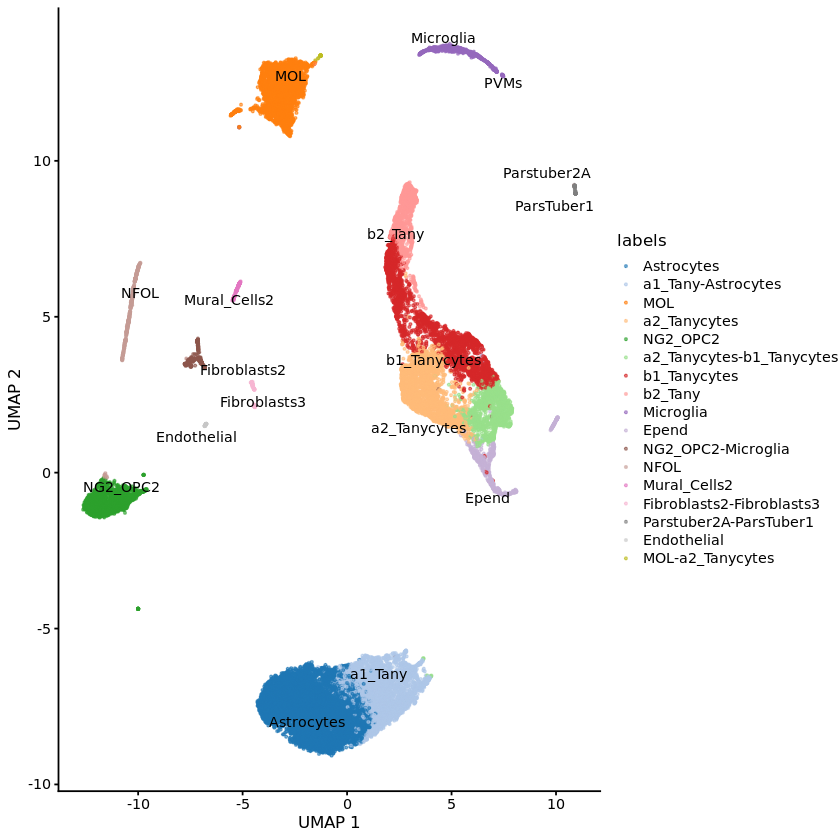

In [50]:
umap_pl

In [52]:
nh_graph_pl <- plotNhoodGraphDA(glia_milo, da_results, layout="UMAP",alpha=0.1, size_range = c(0.5,2)) 

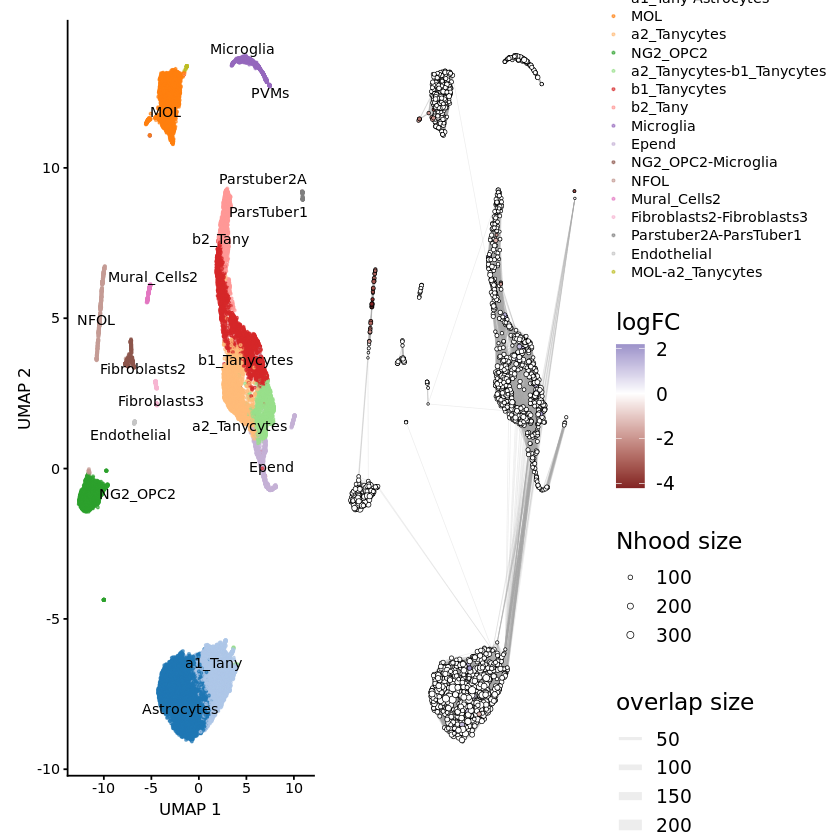

In [53]:
umap_pl + nh_graph_pl +
  plot_layout(guides="collect")

In [58]:
da_results <- annotateNhoods(glia_milo, da_results, coldata_col = "labels")
head(da_results)

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR,labels,labels_fraction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,-0.7552434,9.529559,2.82036153,0.09710648,0.3868923,1,0.3785917,Microglia,1.0000000
2,0.4192172,9.693912,1.15624913,0.28558401,0.5888834,2,0.5727554,a2_Tanycytes-b1_Tanycytes,1.0000000
3,-0.8206259,9.666058,3.85615661,0.05315349,0.3013778,3,0.2957259,Microglia,1.0000000
4,0.1063968,10.310121,0.09459769,0.75923731,0.8968224,4,0.8857505,Astrocytes,1.0000000
5,1.1437303,9.386083,5.87804558,0.01766190,0.1913042,5,0.1982931,b1_Tanycytes,0.9866667
6,0.9846678,9.661383,4.57142018,0.03566373,0.2575269,6,0.2566297,a1_Tany-Astrocytes,1.0000000


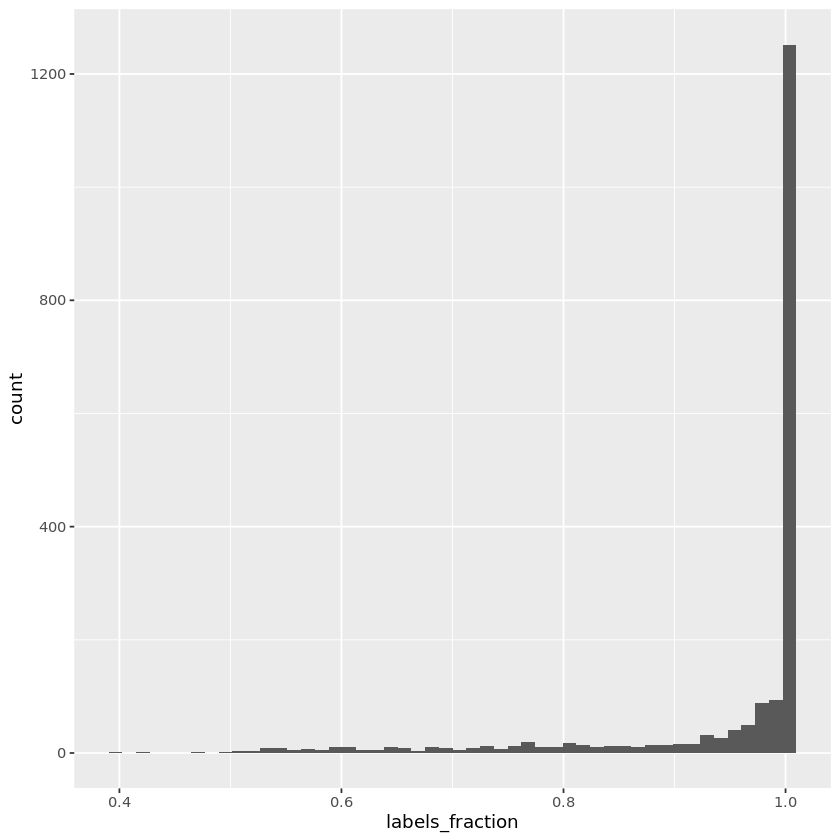

In [59]:
#we want to set a threshold to exclude neighbourhoods with a mix of cell types
ggplot(da_results, aes(labels_fraction)) + geom_histogram(bins=50)

In [60]:
da_results$labels <- ifelse(da_results$labels_fraction < 0.7, "Mixed", da_results$labels)

Converting group.by to factor...



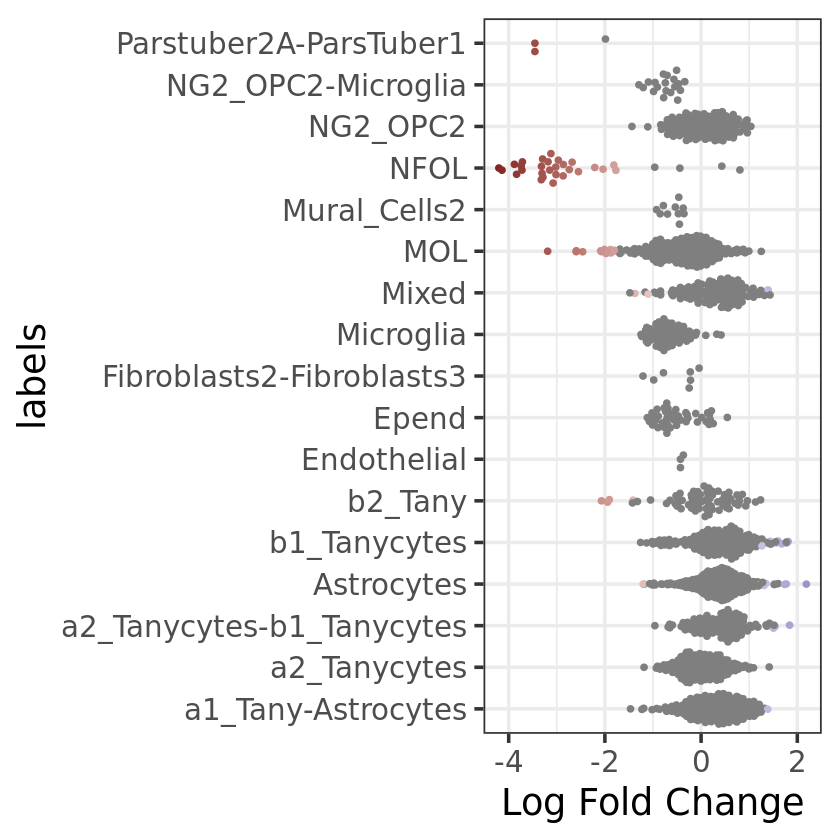

In [61]:
plotDAbeeswarm(da_results, group.by = "labels")